In [1]:
## System
import sys
import os
from collections import defaultdict

## Pandas
import pandas as pd
import numpy as np

## Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Fig utils 
from fig_utils import (get_decile_score, 
                       deciles, 
                       OR_color,
                       AR_color,
                       AD_color,
                       HI_color)


In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/michaelcormier/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
## genic ConSplice file path
autosome_genic_consplice_file = "../data/ConSplice.gene.scores.autosome.txt"
chrx_genic_consplice_file = "../data/ConSplice.gene.scores.chrX.txt"

In [3]:
## score columns
consplice_col = "weighted_sc_percentile"

In [4]:
## Read in the genic ConSplice scores into pandas data frame
autosome_ConSplice_df = pd.read_csv(autosome_genic_consplice_file, sep = "\t", index_col = False)
chrx_ConSplice_df = pd.read_csv(chrx_genic_consplice_file, sep = "\t", index_col = False)
ConSplice_df = pd.concat([autosome_ConSplice_df,chrx_ConSplice_df])

In [5]:
ConSplice_df

,#chrom,txStart,txEnd,strand,gene_id,gene_symbol,transcript_id,max_exon_number,cds_exon_count,zeroton_observed_var_count,...,PHRED_Weighted_O_over_E,One_minus_prop_Weighted_O_over_E,One_over_prop_Weighted_O_over_E,One_over_mr_Weighted_O_over_E,sc_percentile,weighted_sc_percentile,PHRED_weighted_sc_percentile,one_minus_prop_weighted_sc_percentile,one_over_prop_weighted_sc_percentile,one_over_mr_weighted_sc_percentile
0,1,925731,944574,+,ENSG00000187634.12,SAMD11,ENST00000342066.8,14,13,6363.0,...,183.829777,9.870733,154.543203,91.271405,0.059864,0.200394,0.074941,0.062727,0.424264,0.103187
1,1,944203,959256,-,ENSG00000188976.11,NOC2L,ENST00000327044.7,19,19,4781.0,...,485.346247,20.880588,12831.808062,322.778791,0.046950,0.047077,0.046441,0.046886,0.071697,0.046250
2,1,960584,965719,+,ENSG00000187961.14,KLHL17,ENST00000338591.8,12,12,1929.0,...,345.442887,17.616043,5769.152703,176.172721,0.047967,0.081875,0.049176,0.048349,0.130797,0.053820
3,1,966482,975865,+,ENSG00000187583.11,PLEKHN1,ENST00000379410.8,16,16,2586.0,...,223.010655,11.110778,1466.860954,102.002860,0.057319,0.126916,0.062027,0.057955,0.291558,0.088746
4,1,975205,981029,-,ENSG00000187642.9,PERM1,ENST00000433179.3,3,3,1345.0,...,204.348545,9.902423,1535.953136,108.575469,0.068834,0.193078,0.067053,0.062536,0.285960,0.082448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,X,155071503,155123074,+,ENSG00000185515.14,BRCC3,ENST00000369462.5,12,11,6087.0,...,-87.694199,-3.395914,-2154.381158,-111.468330,0.871237,0.881271,0.899666,0.866221,0.844482,0.913043
594,X,155216460,155239841,+,ENSG00000155959.12,VBP1,ENST00000286428.7,6,6,2867.0,...,-41.840864,-1.936133,-891.821503,-12.083077,0.719064,0.658863,0.702341,0.714047,0.638796,0.546823
595,X,155258235,155264491,-,ENSG00000155961.5,RAB39B,ENST00000369454.4,2,2,675.0,...,-112.056336,-5.381423,-1095.505711,-97.908595,0.973244,0.799331,0.949833,0.966555,0.678930,0.872910
596,X,155276211,155334614,-,ENSG00000155962.13,CLIC2,ENST00000369449.7,6,6,7057.0,...,-43.256970,-2.612436,901.402919,-45.057157,0.774247,0.561873,0.705686,0.787625,0.304348,0.667224


In [6]:
## Load gene sets

hi_genes = "../data/HI.genes.tsv"
with open(hi_genes) as hg:
    haploinsufficient_genes = [x.strip() for x in hg]

autosomaldominant_genes = "../data/AD.genes.tsv"
with open(autosomaldominant_genes) as ad:
    ad_genes = [x.strip() for x in ad]
    
autosomalrecessive_genes = "../data/AR.genes.tsv"
with open(autosomalrecessive_genes) as ar:
    ar_genes = [x.strip() for x in ar]
    
olfactoryreceptor_genes = "../data/OR.genes.tsv"
with open(olfactoryreceptor_genes) as org:
    or_genes = [x.strip() for x in org]

In [7]:
## Create new df with gene info 

new_df_list = []

new_df_list.extend([[gene,"Haploinsufficient"] for gene in haploinsufficient_genes])
new_df_list.extend([[gene,"Autosomal Dominant"] for gene in ad_genes])
new_df_list.extend([[gene,"Autosomal Recessive"] for gene in ar_genes])
new_df_list.extend([[gene, "Olfactory Genes"] for gene in or_genes])

gene_list_df = pd.DataFrame(new_df_list, columns = ["gene","gene_list"])

del new_df_list

In [8]:
## Add ConSplice scores to gene df

o_e_gene_set = set(ConSplice_df.gene_symbol)
gene_list_df["ConSplice"] = gene_list_df.gene.apply(lambda x: ConSplice_df.loc[ConSplice_df.gene_symbol == x][consplice_col].values[0] if x in o_e_gene_set else "Missing" )

In [9]:
gene_list_df.groupby("gene_list").describe()

gene                     ConSplice                     
                    count unique     top freq     count unique      top freq
gene_list                                                                   
Autosomal Dominant    709    709  CACNB2    1       709    643  Missing   67
Autosomal Recessive  1183   1183  CC2D2A    1      1183   1086  Missing   98
Haploinsufficient     294    294  GRIN2B    1       294    268  Missing   27
Olfactory Genes       371    371  OR13C8    1       371    181  Missing  191

In [10]:
## Bin scores and normalize counts

gene_list_df["constraint_decile"] = gene_list_df.ConSplice.apply(get_decile_score)

normalized_gene_list_df = gene_list_df.loc[gene_list_df.constraint_decile != "None"].groupby("gene_list")["constraint_decile"].value_counts(normalize=True).reset_index(name='percentage')

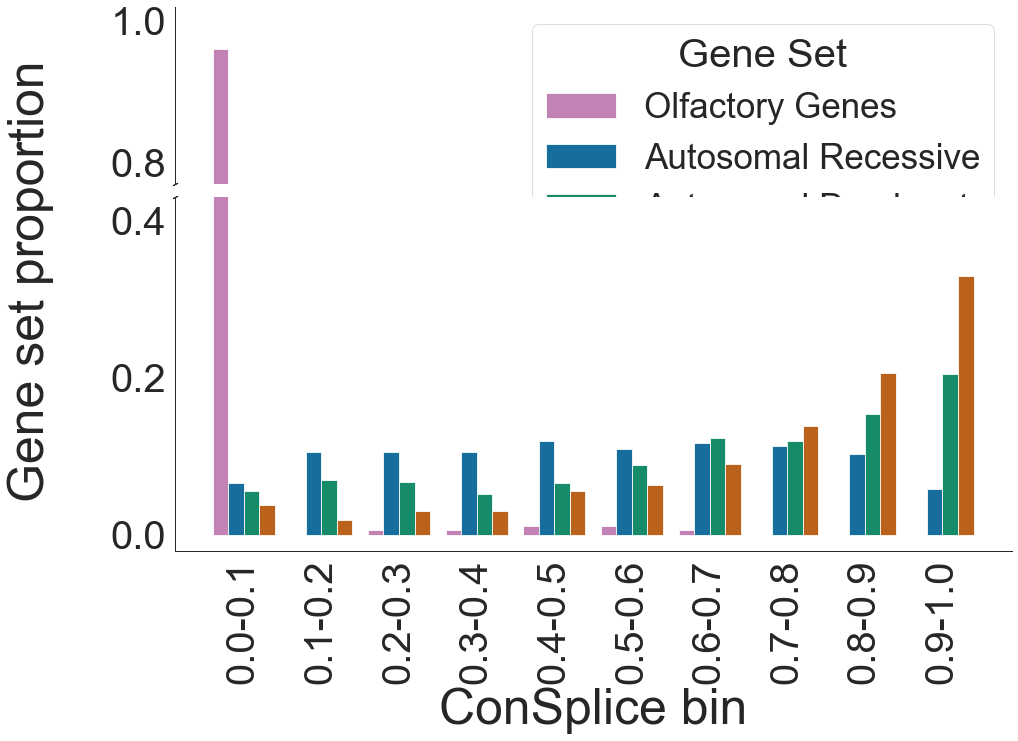

In [12]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]}, sharex=True, figsize = (15,10))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
sns.set(font='Arial', style = "white")
sns.set_context("paper", font_scale = 2)
sns.despine()

hue_order = ["Olfactory Genes","Autosomal Recessive","Autosomal Dominant","Haploinsufficient"]

bplot = sns.barplot(data = normalized_gene_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            hue_order = hue_order,
            order = deciles,
            palette = [OR_color,
                       AR_color,
                       AD_color,
                       HI_color],
            ax = ax1,)

bplot = sns.barplot(data = normalized_gene_list_df, 
            x = "constraint_decile", 
            y = "percentage", 
            hue = "gene_list",
            hue_order = hue_order,
            order = deciles,
            palette = [OR_color,
                       AR_color,
                       AD_color,
                       HI_color],
            ax = ax2,)


ax1.set_ylim(0.77,1.02)
ax2.set_ylim(-0.02,0.43)

ax1.set_ylabel("")
ax1.set_xlabel("")

ax2.set_ylabel("")


fig.text(-0.03, 0.5, 'Gene set proportion', va='center', rotation='vertical', fontsize = 50)

ax2.set_xlabel("ConSplice bin", fontsize = 50)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.tick_params(labeltop=False)  # don't put tick labels at the top

ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.axhline(1, ls='--', color = "black")
ax2.legend().set_visible(False)
ax1.tick_params(axis="x", labelsize=40, )
ax1.tick_params(axis="y", labelsize=40)   
ax2.tick_params(axis="x", which = "both", bottom = False, top = False, labelsize=40, rotation = 90, )
ax2.tick_params(axis="y", labelsize=40)   
ax1.legend(title = "Gene Set", fontsize = 35, title_fontsize = 40, loc = "upper right")

plt.savefig('../figures/suppl_figure3_A.svg')